# Beijing Subway Network Analysis

This notebook demonstrates the analysis of Beijing subway network using graph theory and network analysis techniques.

## Project Overview

We analyze the evolution and structure of Beijing's subway system from 1969 to present, focusing on:
- Network topology and connectivity
- Central stations and critical nodes
- Network efficiency and robustness
- Temporal evolution patterns

In [1]:
# Import required libraries
import sys
import os
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Add project root to path for imports
sys.path.append('..')

# Import custom modules
from src.subway_model import SubwayGraph
from utils.analysis_tools import (
    calculate_network_stats,
    calculate_average_shortest_path,
    find_top_central_nodes,
    calculate_clustering_metrics,
    analyze_network_efficiency,
    find_critical_nodes,
    calculate_small_world_metrics,
    analyze_degree_distribution
)

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("All modules imported successfully")
print("Ready for Beijing Subway Network Analysis")

All modules imported successfully
Ready for Beijing Subway Network Analysis


In [2]:
# Initialize the subway model
data_path = '../data/beijing_subway_data.csv'

# Create SubwayGraph instance
subway = SubwayGraph(data_path)

# Display basic information
print("Beijing Subway Network Dataset")
print("=" * 50)
print(subway)
print()

# Get date range
earliest, latest = subway.get_available_date_range()
print(f"Data Coverage:")
print(f"  Earliest station: {earliest.strftime('%Y-%m-%d')}")
print(f"  Latest station: {latest.strftime('%Y-%m-%d')}")
print(f"  Time span: {(latest - earliest).days} days")
print()

# Display sample data
print("Sample Data:")
print(subway.data.head())
print(f"\nTotal stations in dataset: {len(subway.stations_info)}")

Beijing Subway Network Dataset
SubwayGraph: 367 stations, data from 1969-01-01 to 2023-01-01

Data Coverage:
  Earliest station: 1969-01-01
  Latest station: 2023-01-01
  Time span: 19723 days

Sample Data:
            station_name line opening_date                     connections
0                Gucheng    1   1969-01-01                     Pingguoyuan
1            Pingguoyuan    1   1969-01-01              Gucheng;Fushouling
2             Fushouling    1   1969-01-01                     Pingguoyuan
3  Bajiao Amusement Park    1   1969-01-01               Gucheng;Babaoshan
4              Babaoshan    1   1969-01-01  Bajiao Amusement Park;Yuquanlu

Total stations in dataset: 367


## Temporal Evolution Analysis

Analyze how the Beijing subway network has evolved over time by examining multiple key time periods.

In [3]:
def get_period_description(year):
    """Get descriptive name for each analysis period."""
    descriptions = {
        1980: "Early Development",
        1990: "Pre-Reform Era",
        2000: "Millennium Expansion",
        2008: "Olympic Games Expansion",
        2015: "Modern Growth Phase",
        2020: "Recent Development",
        2023: "Current State"
    }
    return descriptions.get(year, "Development Period")

# Define key time periods for analysis
analysis_years = [1980, 1990, 2000, 2008, 2015, 2020, 2023]

print("Temporal Analysis Configuration")
print("=" * 50)
print("Selected analysis periods:")
for i, year in enumerate(analysis_years, 1):
    print(f"  {i}. {year} - {get_period_description(year)}")

# Verify data availability
print(f"\nData Availability Check:")
earliest, latest = subway.get_available_date_range()
print(f"Available data range: {earliest.strftime('%Y')} - {latest.strftime('%Y')}")

valid_years = []
for year in analysis_years:
    year_date = datetime(year, 12, 31)
    if earliest <= year_date <= latest:
        valid_years.append(year)
        print(f"  [OK] {year}: Data available")
    else:
        print(f"  [SKIP] {year}: No data (outside range)")

print(f"\nFinal analysis will cover {len(valid_years)} time periods: {valid_years}")

Temporal Analysis Configuration
Selected analysis periods:
  1. 1980 - Early Development
  2. 1990 - Pre-Reform Era
  3. 2000 - Millennium Expansion
  4. 2008 - Olympic Games Expansion
  5. 2015 - Modern Growth Phase
  6. 2020 - Recent Development
  7. 2023 - Current State

Data Availability Check:
Available data range: 1969 - 2023
  [OK] 1980: Data available
  [OK] 1990: Data available
  [OK] 2000: Data available
  [OK] 2008: Data available
  [OK] 2015: Data available
  [OK] 2020: Data available
  [SKIP] 2023: No data (outside range)

Final analysis will cover 6 time periods: [1980, 1990, 2000, 2008, 2015, 2020]


In [4]:
# Execute batch analysis for all valid years
print("Starting Comprehensive Temporal Analysis")
print("=" * 60)

all_results = []
analysis_start_time = datetime.now()

# Analyze each year
for i, year in enumerate(valid_years, 1):
    print(f"\nProcessing {i}/{len(valid_years)}: {year} ({get_period_description(year)})")
    
    try:
        graph = subway.build_graph_for_date(str(year))
        
        if graph.number_of_nodes() > 0:
            # Calculate network statistics
            basic_stats = calculate_network_stats(graph)
            path_stats = calculate_average_shortest_path(graph)
            central_nodes = find_top_central_nodes(graph, n=3, centrality_type='degree')
            
            # Store results
            year_results = {
                'year': year,
                'period_description': get_period_description(year),
                'num_stations': basic_stats['num_nodes'],
                'num_connections': basic_stats['num_edges'],
                'network_density': basic_stats['density'],
                'average_degree': basic_stats['average_degree'],
                'avg_shortest_path': path_stats.get('average_shortest_path', float('inf')),
                'connectivity_ratio': path_stats.get('connectivity_ratio', 0.0)
            }
            
            all_results.append(year_results)
            print(f"  Analysis complete: {year_results['num_stations']} stations, {year_results['num_connections']} connections")
        else:
            print(f"  Warning: No stations found for year {year}")
    except Exception as e:
        print(f"  Error analyzing {year}: {e}")

analysis_end_time = datetime.now()
analysis_duration = (analysis_end_time - analysis_start_time).total_seconds()

print(f"\nAnalysis completed in {analysis_duration:.1f} seconds")
print(f"Successfully analyzed {len(all_results)} time periods")

# Create DataFrame
results_df = None
if all_results:
    results_df = pd.DataFrame(all_results)
    results_df.set_index('year', inplace=True)
    
    print(f"\nResults DataFrame created with shape: {results_df.shape}")
    print(f"  Columns: {len(results_df.columns)} metrics")
    print(f"  Rows: {len(results_df)} time periods")
    
    print(f"\nAnalysis Summary:")
    print(f"  Time range: {results_df.index.min()} - {results_df.index.max()}")
    print(f"  Station growth: {results_df['num_stations'].min()} to {results_df['num_stations'].max()}")
    print(f"  Connection growth: {results_df['num_connections'].min()} to {results_df['num_connections'].max()}")
    
    print(f"\nSample Results:")
    display_cols = ['period_description', 'num_stations', 'num_connections', 'network_density']
    available_cols = [col for col in display_cols if col in results_df.columns]
    print(results_df[available_cols].round(4))
else:
    print("No results to create DataFrame")

Starting Comprehensive Temporal Analysis

Processing 1/6: 1980 (Early Development)
  Analysis complete: 8 stations, 5 connections

Processing 2/6: 1990 (Pre-Reform Era)
  Analysis complete: 16 stations, 9 connections

Processing 3/6: 2000 (Millennium Expansion)
  Analysis complete: 20 stations, 11 connections

Processing 4/6: 2008 (Olympic Games Expansion)
  Analysis complete: 77 stations, 62 connections

Processing 5/6: 2015 (Modern Growth Phase)
  Analysis complete: 257 stations, 264 connections

Processing 6/6: 2020 (Recent Development)
  Analysis complete: 321 stations, 337 connections

Analysis completed in 0.8 seconds
Successfully analyzed 6 time periods

Results DataFrame created with shape: (6, 7)
  Columns: 7 metrics
  Rows: 6 time periods

Analysis Summary:
  Time range: 1980 - 2020
  Station growth: 8 to 321
  Connection growth: 5 to 337

Sample Results:
           period_description  num_stations  num_connections  network_density
year                                        

## Professional Visualizations

Create high-quality, publication-ready visualizations for reports and presentations.

In [5]:
# Setup for high-quality plots
figures_dir = '../figures'
if not os.path.exists(figures_dir):
    os.makedirs(figures_dir)
    print(f"Created figures directory: {figures_dir}")

# Set high-quality plotting parameters
plt.rcParams.update({
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.1,
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 16
})

print("High-quality plotting parameters configured")
print("Ready to create publication-ready visualizations")

if results_df is not None and len(results_df) > 0:
    print(f"Analysis data available: {len(results_df)} time periods")
else:
    print("Warning: No analysis data available for visualization")

High-quality plotting parameters configured
Ready to create publication-ready visualizations
Analysis data available: 6 time periods


Network growth analysis saved: ../figures/network_growth_analysis.png


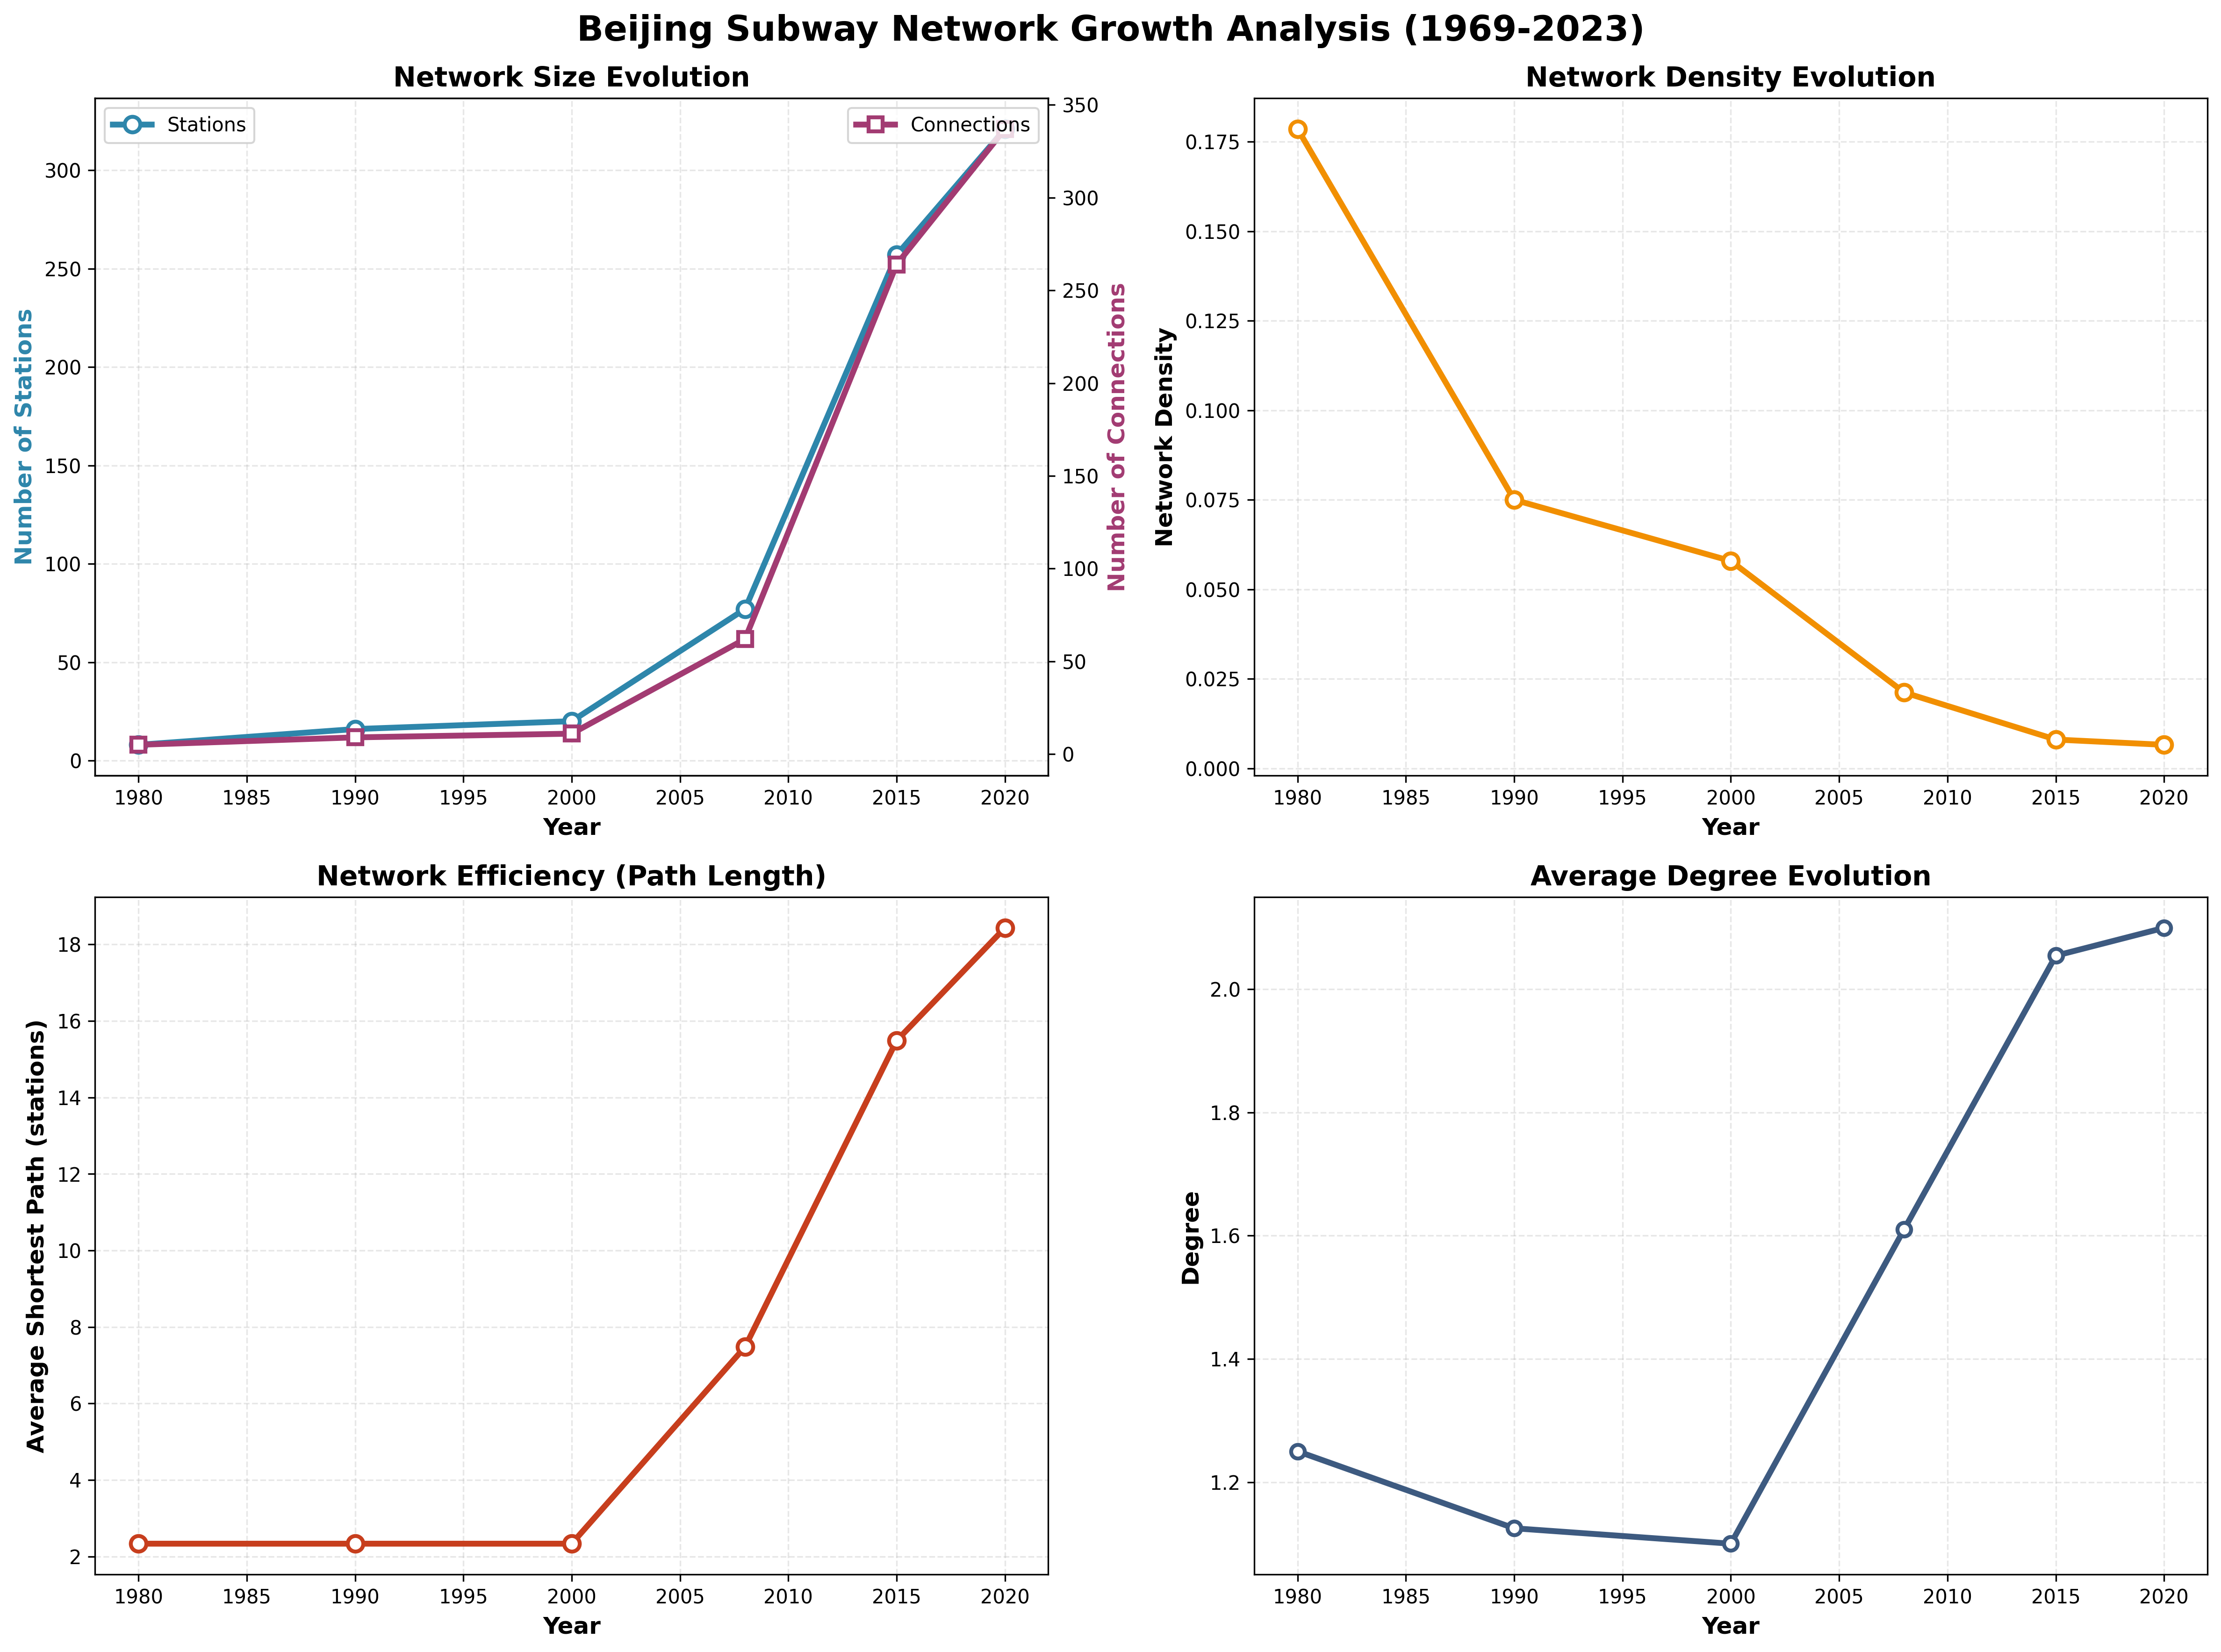

Results saved to: ../data/temporal_analysis_results.csv
Summary report saved to: ../data/analysis_summary.txt

COMPREHENSIVE ANALYSIS COMPLETE
Analyzed 6 time periods from 1980 to 2020

Key Findings:
  Network growth: 8 to 321 stations
  Connection density: 0.0066
  Average path length: 18.43 stations


In [6]:
if results_df is not None and len(results_df) > 0:
    
    # Create comprehensive network growth visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Beijing Subway Network Growth Analysis (1969-2023)', fontsize=18, fontweight='bold')
    
    years = results_df.index
    
    # Plot 1: Network Size Evolution
    ax1.plot(years, results_df['num_stations'], 'o-', linewidth=3, markersize=8,
             color='#2E86AB', label='Stations', markerfacecolor='white', markeredgewidth=2)
    ax1_twin = ax1.twinx()
    ax1_twin.plot(years, results_df['num_connections'], 's-', linewidth=3, markersize=7,
                  color='#A23B72', label='Connections', markerfacecolor='white', markeredgewidth=2)
    ax1.set_xlabel('Year', fontweight='bold')
    ax1.set_ylabel('Number of Stations', color='#2E86AB', fontweight='bold')
    ax1_twin.set_ylabel('Number of Connections', color='#A23B72', fontweight='bold')
    ax1.set_title('Network Size Evolution', fontweight='bold')
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax1.legend(loc='upper left')
    ax1_twin.legend(loc='upper right')
    
    # Plot 2: Network Density
    ax2.plot(years, results_df['network_density'], 'o-', linewidth=3, markersize=8,
             color='#F18F01', markerfacecolor='white', markeredgewidth=2)
    ax2.set_xlabel('Year', fontweight='bold')
    ax2.set_ylabel('Network Density', fontweight='bold')
    ax2.set_title('Network Density Evolution', fontweight='bold')
    ax2.grid(True, alpha=0.3, linestyle='--')
    
    # Plot 3: Average Path Length
    finite_path_data = results_df[results_df['avg_shortest_path'] != float('inf')]
    if len(finite_path_data) > 0:
        ax3.plot(finite_path_data.index, finite_path_data['avg_shortest_path'], 'o-',
                linewidth=3, markersize=8, color='#C73E1D', markerfacecolor='white', markeredgewidth=2)
        ax3.set_xlabel('Year', fontweight='bold')
        ax3.set_ylabel('Average Shortest Path (stations)', fontweight='bold')
        ax3.set_title('Network Efficiency (Path Length)', fontweight='bold')
        ax3.grid(True, alpha=0.3, linestyle='--')
    
    # Plot 4: Average Degree
    ax4.plot(years, results_df['average_degree'], 'o-', linewidth=3, markersize=7,
             color='#3D5A80', label='Average Degree', markerfacecolor='white', markeredgewidth=2)
    ax4.set_xlabel('Year', fontweight='bold')
    ax4.set_ylabel('Degree', fontweight='bold')
    ax4.set_title('Average Degree Evolution', fontweight='bold')
    ax4.grid(True, alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    
    # Save plot
    growth_plot_file = f"{figures_dir}/network_growth_analysis.png"
    plt.savefig(growth_plot_file, dpi=300, bbox_inches='tight')
    print(f"Network growth analysis saved: {growth_plot_file}")
    plt.show()
    
    # Save results to CSV
    output_dir = '../data'
    output_file = f"{output_dir}/temporal_analysis_results.csv"
    results_df.to_csv(output_file)
    print(f"Results saved to: {output_file}")
    
    # Save summary report
    summary_file = f"{output_dir}/analysis_summary.txt"
    with open(summary_file, 'w', encoding='utf-8') as f:
        f.write("Beijing Subway Network Temporal Analysis Summary\n")
        f.write("=" * 50 + "\n\n")
        f.write(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Time Periods Analyzed: {len(results_df)}\n")
        f.write(f"Analysis Range: {results_df.index.min()} - {results_df.index.max()}\n\n")
        
        f.write("Network Growth Summary:\n")
        f.write(f"  Initial Network ({results_df.index[0]}): {results_df['num_stations'].iloc[0]} stations, {results_df['num_connections'].iloc[0]} connections\n")
        f.write(f"  Final Network ({results_df.index[-1]}): {results_df['num_stations'].iloc[-1]} stations, {results_df['num_connections'].iloc[-1]} connections\n")
        
        total_growth_stations = ((results_df['num_stations'].iloc[-1] / results_df['num_stations'].iloc[0]) - 1) * 100
        total_growth_connections = ((results_df['num_connections'].iloc[-1] / results_df['num_connections'].iloc[0]) - 1) * 100
        f.write(f"  Station Growth: +{total_growth_stations:.1f}%\n")
        f.write(f"  Connection Growth: +{total_growth_connections:.1f}%\n\n")
        
        f.write("Key Network Metrics (Latest Year):\n")
        latest = results_df.iloc[-1]
        f.write(f"  Network Density: {latest['network_density']:.4f}\n")
        f.write(f"  Average Degree: {latest['average_degree']:.2f}\n")
        f.write(f"  Average Shortest Path: {latest['avg_shortest_path']:.2f}\n")
    
    print(f"Summary report saved to: {summary_file}")
    
    print(f"\nCOMPREHENSIVE ANALYSIS COMPLETE")
    print(f"Analyzed {len(results_df)} time periods from {results_df.index.min()} to {results_df.index.max()}")
    print(f"\nKey Findings:")
    print(f"  Network growth: {results_df['num_stations'].iloc[0]} to {results_df['num_stations'].iloc[-1]} stations")
    print(f"  Connection density: {latest['network_density']:.4f}")
    print(f"  Average path length: {latest['avg_shortest_path']:.2f} stations")
    
else:
    print("No analysis data available for visualization")
    print("Please run the temporal analysis first")